## Final Project

In [99]:
import os
import sys
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

Setting the random seed for reproducibility

In [100]:
random.seed(42)
np.random.seed(42)

## Reading the Data

Due to the large amount of records in the CSV files, we set low_memory=False to ensure that the data is read in correctly.

In [101]:
x_train_df = pd.read_csv("./data/train_x.csv", low_memory=False)
y_train_df = pd.read_csv("./data/train_y.csv", low_memory=False)
x_test_df = pd.read_csv("./data/test_x.csv", low_memory=False)

## Remove Unnecessary Columns / Features

Here we want to remove any columns that are not necessary for our analysis. We will remove the following columns:

-   `Unnamed: 0`
-   `cellattributevalue`
-   `celllabel`
-   `labmeasurenamesystem`
-   `labname`
-   `labresult`

We deem these columns unnecessary because they do not provide any useful information for our analysis or the sparse data will not be useful for our training.

In [102]:
new_x_train_df = x_train_df.drop(columns=["Unnamed: 0", "cellattributevalue", "celllabel", "labmeasurenamesystem", "labname", "labresult"])
new_x_test_df = x_test_df.drop(columns=["Unnamed: 0", "cellattributevalue", "celllabel", "labmeasurenamesystem", "labname", "labresult"])
new_y_train_df = y_train_df["hospitaldischargestatus"]

## Preprocessing

In [103]:
new_x_train_df.sort_values(by=["patientunitstayid"], inplace=True)
new_x_test_df.sort_values(by=["patientunitstayid"], inplace=True)

In [104]:
new_x_train_df["age"].replace("> 89", 90, inplace=True)
new_x_train_df["age"] = new_x_train_df["age"].astype("float64")
new_x_train_df["nursingchartvalue"].replace("Unable to score due to medication", np.nan, inplace=True)
new_x_train_df["nursingchartvalue"] = new_x_train_df["nursingchartvalue"].astype("float64")

new_x_test_df["age"].replace("> 89", 90, inplace=True)
new_x_test_df["age"] = new_x_test_df["age"].astype("float64")
new_x_test_df["nursingchartvalue"].replace("Unable to score due to medication", np.nan, inplace=True)
new_x_test_df["nursingchartvalue"] = new_x_test_df["nursingchartvalue"].astype("float64")

In [105]:
def encode_data(train_df: pd.DataFrame, test_df: pd.DataFrame):
    # Combine the training and test data
    combined_df = pd.concat([train_df, test_df], axis=0)

    numerical = combined_df.select_dtypes(include=["int64", "float64"])
    nonnumerical = combined_df.select_dtypes(exclude=["int64", "float64"])
    categorical = pd.get_dummies(nonnumerical)

    # Split the combined data back into training and test data
    n_train = len(train_df)
    train_categorical = categorical.iloc[:n_train]
    test_categorical = categorical.iloc[n_train:]

    train_data = pd.concat([numerical[:n_train], train_categorical], axis=1)
    test_data = pd.concat([numerical[n_train:], test_categorical], axis=1)

    return train_data, test_data

In [106]:
new_x_train_df, new_x_test_df = encode_data(new_x_train_df, new_x_test_df)

print(new_x_train_df.shape)
print(new_x_test_df.shape)

(791936, 25)
(225895, 25)


In [107]:
nursing_chart_types = [col for col in new_x_train_df.columns if col.startswith("nursingchartcelltypevalname")]
for nursing_chart_type in nursing_chart_types:
    new_x_train_df[nursing_chart_type] = new_x_train_df.apply(lambda row: row['nursingchartvalue'] if row[nursing_chart_type] == 1 else 0, axis=1)
    new_x_test_df[nursing_chart_type] = new_x_test_df.apply(lambda row: row['nursingchartvalue'] if row[nursing_chart_type] == 1 else 0, axis=1)

new_x_train_df.drop(columns=["nursingchartvalue"], inplace=True)
new_x_test_df.drop(columns=["nursingchartvalue"], inplace=True)

In [108]:
def aggregate_data(df: pd.DataFrame):
    agg_dict = {
        "offset": "sum",
        "admissionheight": "max",
        "admissionweight": "max",
        "age": "max",
        "unitvisitnumber": "max",
        "ethnicity_African American": "max",
        "ethnicity_Asian": "max",
        "ethnicity_Caucasian": "max",
        "ethnicity_Hispanic": "max",
        "ethnicity_Native American": "max",
        "ethnicity_Other/Unknown": "max",
        "gender_Female": "max",
        "gender_Male": "max",
        "nursingchartcelltypevalname_GCS Total": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Heart Rate": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Invasive BP Diastolic": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Invasive BP Mean": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Invasive BP Systolic": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Non-Invasive BP Diastolic": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Non-Invasive BP Mean": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Non-Invasive BP Systolic": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_O2 Saturation": lambda x: x[x != 0].mean(),
        "nursingchartcelltypevalname_Respiratory Rate": lambda x: x[x != 0].mean(),
    }
    grouped_df = df.groupby("patientunitstayid").agg(agg_dict)
    grouped_df.reset_index(inplace=True)
    return grouped_df

In [109]:
new_x_train_df = aggregate_data(new_x_train_df)
new_x_test_df = aggregate_data(new_x_test_df)

In [110]:
numerical = new_x_train_df.select_dtypes(include=["int64", "float64"])
numerical.fillna(0, inplace=True)
new_x_train_df.update(numerical)

numerical = new_x_test_df.select_dtypes(include=["int64", "float64"])
numerical.fillna(0, inplace=True)
new_x_test_df.update(numerical)

In [111]:
print(new_x_train_df.shape)
print(new_y_train_df.shape)

(2016, 24)
(2016,)


## Building Our Model

Attempting GridSearch

In [ ]:
parameters = {
    "learning_rate": [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.2],
    "min_samples_split": [1, 2, 5, 10],
    "min_samples_leaf": [1, 2, 4, 6, 8],
    "max_depth": [3, 5, 8],
    "max_features": ["log2", "sqrt"],
}

grid_search = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1, verbose=10)
grid_search.fit(new_x_train_df, new_y_train_df)

print("Finished Grid Search ({}) | Best Params: {}".format(grid_search.score(new_x_train_df, new_y_train_df), grid_search.best_params_))

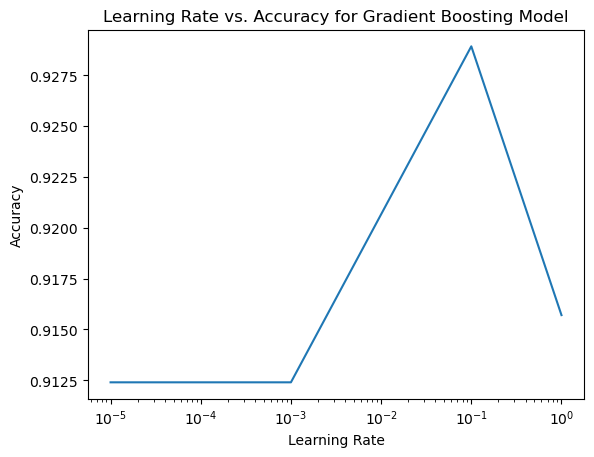

Accuracy: [0.915702479338843, 0.9289256198347108, 0.912396694214876, 0.912396694214876, 0.912396694214876]
Log Loss: 0.2229636368967961


In [112]:
train_x, test_x, train_y, test_y = train_test_split(new_x_train_df, new_y_train_df, random_state=42, train_size= 0.7)

# Create a Gradient Boosting Classifier model
model = GradientBoostingClassifier(learning_rate=.1, loss="exponential")
lr_list = [1,0.1,0.001, 0.0001,0.00001]
acc = []
for lr in lr_list:
    # Change the learning rate 
    model.set_params(learning_rate=lr)
    # Train the model on the data
    model.fit(train_x, train_y)

    # Generate predictions on the test set
    y_pred = model.predict(test_x)

    # Compute the accuracy of the model
    acc.append(accuracy_score(test_y, y_pred))

# Plot the learning rate vs. accuracy
plt.plot(lr_list, acc)
plt.title('Learning Rate vs. Accuracy for Gradient Boosting Model')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
# Set the x-axis to log scale
plt.xscale('log')
plt.show()

print("Accuracy:", acc)

model = GradientBoostingClassifier(learning_rate=.1, loss="exponential")
model.fit(train_x, train_y)
# Generate class probabilities on the test set
y_proba = model.predict_proba(test_x)

# Compute the log loss of the model
log_loss = log_loss(test_y, y_proba)

print("Log Loss:", log_loss)

In [113]:

y_pred = model.predict_proba(new_x_test_df)

test_patient_ids = new_x_test_df['patientunitstayid']
submission_df = pd.DataFrame({'patientunitstayid': test_patient_ids, 'hospitaldischargestatus': y_pred[:, 1]})

submission_df["patientunitstayid"] = submission_df["patientunitstayid"].astype("int64")
submission_df.to_csv('submission.csv', index=False)